In [31]:
import cv2
import numpy as np

def segment_date_by_dots(date_image):

    if len(date_image.shape) == 3:
        gray = cv2.cvtColor(date_image, cv2.COLOR_BGR2GRAY)
    else:
        gray = date_image.copy()
    

    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    

    components = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        components.append({
            'x': x, 'width': w, 'height': h,
            'image': binary[y:y+h, x:x+w]
        })
    

    components.sort(key=lambda c: c['x'])
    

    dots = []
    digits = []
    
    for comp in components:
        if comp["width"] < 0.5 * comp["height"]: 
            dots.append(comp['x'] + comp['width']/2)  
        else:
            digits.append(comp)
    

    if len(dots) >= 2:
        
        day_digits = [d for d in digits if d['x'] < dots[0]]
        
        month_digits = [d for d in digits if dots[0] < d['x'] < dots[1]]
        
        year_digits = [d for d in digits if d['x'] > dots[1]]
    else:
        
        day_digits = digits[:1]  
        month_digits = digits[1:2]  
        year_digits = digits[2:]  
    
    def combine_digits(digit_list):
        if not digit_list:
            return None

        digit_list.sort(key=lambda d: d['x'])
 
        images = [d['image'] for d in digit_list]

        total_width = sum(img.shape[1] for img in images) + (len(images)-1)*2
        max_height = max(img.shape[0] for img in images)
        
        combined = np.zeros((max_height, total_width), dtype=np.uint8)
        x_offset = 0
        for img in images:
            h, w = img.shape
            y_offset = (max_height - h) // 2
            combined[y_offset:y_offset+h, x_offset:x_offset+w] = img
            x_offset += w + 2
        
        return combined
    
    return combine_digits(day_digits), combine_digits(month_digits), combine_digits(year_digits)

In [34]:
import cv2
import numpy as np

def segment_date_by_dot(img):

    # 1 — Convert to grayscale
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()

    # 2 — Otsu invert (digits → white)
    _, binv = cv2.threshold(gray, 0, 255,
                            cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # 3 — Find connected components
    contours, _ = cv2.findContours(
        binv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    comps = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        comps.append({
            "x": x, "y": y, "w": w, "h": h,
            "img": binv[y:y+h, x:x+w]
        })

    # 4 — Sort by x-coordinate
    comps.sort(key=lambda c: c["x"])

    # 5 — dot detection: dots are 1–3 pixels
    dots = []
    digits = []

    for c in comps:
        w, h = c["w"], c["h"]

        # REAL for your handwritten sample:
        # dot = (1–3 px width and height)
        if w <= 3 and h <= 3:
            dots.append(c["x"])
        else:
            digits.append(c)

    if len(dots) < 2:
        print("Not enough dots found.")
        return None, None, None

    # use leftmost two dots
    dots = sorted(dots)
    d1, d2 = dots[0], dots[1]

    # 6 — Split digits
    day   = [d for d in digits if d["x"] < d1]
    month = [d for d in digits if d1 < d["x"] < d2]
    year  = [d for d in digits if d["x"] > d2]

    return combine(day), combine(month), combine(year)


# --------------------
# Combine digits helper
# --------------------
def combine(dlist):
    if not dlist:
        return None

    dlist.sort(key=lambda d: d["x"])
    imgs = [d["img"] for d in dlist]

    total_w = sum(i.shape[1] for i in imgs) + (len(imgs)-1)*3
    max_h = max(i.shape[0] for i in imgs)

    canvas = np.zeros((max_h, total_w), dtype=np.uint8)

    x_offset = 0
    for img in imgs:
        h, w = img.shape
        y_offset = (max_h - h) // 2
        canvas[y_offset:y_offset+h, x_offset:x_offset+w] = img
        x_offset += w + 3

    return canvas


In [1]:
def segment_fixed_width(date_image):
    """Assume equal-ish spacing"""
    height, width = date_image.shape[:2]
    
    day_end = width // 3
    month_end = 2 * width // 3
    
    day_img = date_image[:, :day_end]
    month_img = date_image[:, day_end:month_end]
    year_img = date_image[:, month_end:]
    
    return day_img, month_img, year_img

In [27]:
import matplotlib.pyplot as plt

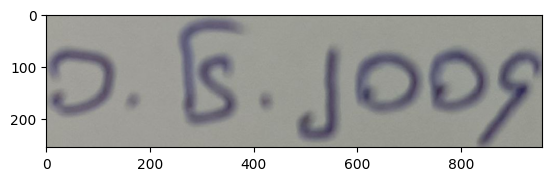

In [5]:
img = cv2.imread("16.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [32]:
dn, mn, yn = segment_date_by_dots(img)

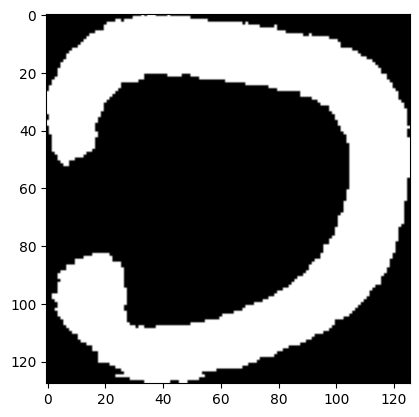

In [33]:
plt.imshow(dn, cmap="gray")

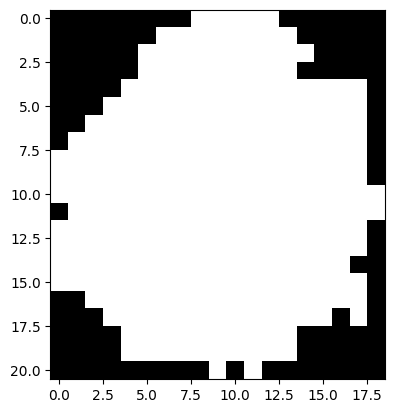

In [24]:
plt.imshow(mn, cmap="gray")

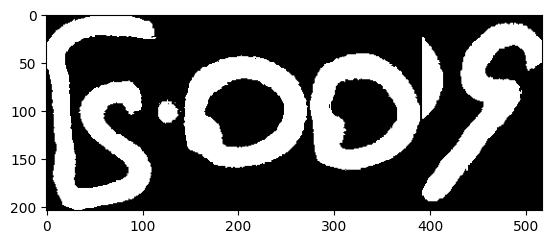

In [25]:
plt.imshow(yn, cmap="gray")

In [35]:
d, m, y = segment_date_by_dot(img)

Not enough dots found.


In [1]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image

In [4]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-large-handwritten")
model     = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-large-handwritten")

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.23G [00:00<?, ?B/s]

In [3]:
image = Image.open("16.jpg")